In [24]:
%matplotlib inline
import os
os.chdir('/vco260/')

In [2]:
from src.gene_collaborative_filtering import *
from src.datadownload import *

pd.options.display.max_colwidth=200

Using TensorFlow backend.


# download data

In [3]:
uni=Uniprot()

100%|██████████| 19/19 [00:29<00:00,  2.65s/it]

       organism num_of_proteins          date_of_download
0      cucumber           24734  Thu Jan 24 14:51:13 2019
1         onion             444  Thu Jan 24 14:49:41 2019
2        cotton           78452  Mon Jan 28 09:40:59 2019
3       soybean           86802  Thu Jan 24 15:00:12 2019
4          rice            4628  Thu Jan 24 14:49:53 2019
5         melon           25319  Thu Jan 24 14:50:57 2019
6        pepper           75332  Mon Jan 28 09:43:22 2019
7    watermelon             315  Thu Jan 24 14:49:39 2019
8   arabidopsis           89243  Thu Jan 24 14:57:47 2019
9        tomato           35894  Mon Jan 28 09:38:50 2019
10     eggplant             429  Thu Jan 24 14:49:40 2019
11        pikea            8147  Thu Jan 24 14:53:50 2019
12     ryegrass             166  Thu Jan 24 14:49:35 2019
13        wheat          142646  Thu Jan 24 15:01:15 2019
14        sprus           11387  Thu Jan 24 14:55:38 2019
15        oryza          122586  Thu Jan 24 15:00:23 2019
16      cabbag

In [4]:
gene=Gene()

100%|██████████| 19/19 [00:05<00:00,  2.35it/s]

       organism num_of_proteins          date_of_download
0         pikea             114  Thu Jan 24 15:06:09 2019
1        potato           35146  Thu Jan 24 15:30:23 2019
2        tomato           37832  Thu Jan 24 15:21:50 2019
3      cucumber           32343  Thu Jan 24 15:35:37 2019
4    watermelon             185  Thu Jan 24 14:55:32 2019
5         oryza           94869  Thu Jan 24 15:11:56 2019
6         melon           24603  Thu Jan 24 15:13:39 2019
7         onion             179  Thu Jan 24 15:28:13 2019
8      ryegrass             133  Thu Jan 24 14:49:32 2019
9         Maize           66975  Thu Jan 24 15:06:07 2019
10        wheat            2285  Thu Jan 24 14:55:30 2019
11         rice           95489  Thu Jan 24 14:55:20 2019
12       pepper           41730  Thu Jan 24 15:33:13 2019
13  arabidopsis           44111  Thu Jan 24 15:28:12 2019
14        sprus              99  Thu Jan 24 14:55:22 2019
15     eggplant             133  Thu Jan 24 15:35:38 2019
16       cotto

In [5]:
exp=Expression()

100%|██████████| 19/19 [00:02<00:00,  8.66it/s]

       organism num_of_experiments          date_of_download
0         pikea                  0  Thu Jan 24 15:21:22 2019
1        cotton                  0  Thu Jan 24 15:21:22 2019
2      eggplant                  0  Thu Jan 24 15:21:22 2019
3   arabidopsis                533  Thu Jan 24 15:25:06 2019
4         sprus                  0  Thu Jan 24 15:21:22 2019
5         oryza                  0  Thu Jan 24 15:21:22 2019
6          rice                 82  Thu Jan 24 15:22:15 2019
7       soybean                 20  Thu Jan 24 15:22:18 2019
8        pepper                  0  Thu Jan 24 15:21:22 2019
9         Maize                 36  Thu Jan 24 15:22:19 2019
10      cabbage                  1  Thu Jan 24 15:21:37 2019
11        melon                  0  Thu Jan 24 15:21:22 2019
12     ryegrass                  0  Thu Jan 24 15:21:22 2019
13       potato                  7  Thu Jan 24 15:21:36 2019
14        wheat                 15  Thu Jan 24 15:22:10 2019
15       tomato         

# collaborative filtering data preparations
1. the purpose of this notebook is to prepare data for collaborative filtering that is agreed upon. 
2. needed: downloaded data

### get_uniprot_colab_data function:
#### works on load raw gene data which merges ALL dataframes
##### loads cached result if not redo
1. column name - select column for collaborative filtering with the uniprot id ('go',pubmeb id, 
2. cut_off_col_per_idx - for go terms and uniprot id means at least x go terms per uniprot id(x=2 by default)
3. cut_off_idx_per_col - filter out go terms with less the x uniprot id related to them(x=2 by default)
4. redo - merges again using chosen column and new filter cut offs (does not redownload data)


In [7]:
min_gene_per_go=5
min_go_per_gene = 2
df,codes=get_uniprot_colab_data('go',cut_off_col_per_idx=min_go_per_gene,cut_off_idx_per_col=min_gene_per_go,redo=False)
df=df.drop_duplicates()

/vco260/src/dataprocess.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  temp[feature]=temp[feature].astype(str).str.lstrip().str.rstrip()
/vco260/src/dataprocess.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  temp[feature]=temp[feature].str.split(split_on)

100%|██████████| 2/2 [00:00<00:00,  8.17it/s]


## create additional test set composed of 5 entries per organism

In [8]:
merged=pd.read_parquet(load_raw_gene_data())
merged_dropna_go=merged.dropna(subset=['go'])

In [44]:
if not os.path.isfile('data/additional_test_set.pickle'):
    additional_test_set=[]
    for org in merged_dropna_go.Organism.unique():
        additional_test_set+=merged_dropna_go[merged_dropna_go.Organism==org].sample(10)['Entry'].values.tolist()
    additional_test_set_idx=[list(codes[0]).index(x) for x in additional_test_set]
    save_to_pickle(additional_test_set_idx,fileadd='data/additional_test_set_idx.pickle')
    save_to_pickle(additional_test_set,fileadd='data/additional_test_set.pickle')    

In [ ]:
#remove data point with entries that belong to additional_test_set_idx
df=df[~df.Entry_categorical.isin(additional_test_set_idx)]
df.to_parquet('data/positive_collab.parquet')

# test conversion codes

In [ ]:
test_conversion(df,merged,codes,verbose=True)

temp=[]
for j in tqdm(range(100)): temp.append(test_conversion(df,merged,codes))
all(temp)

# create batches for negative pairs

In [ ]:
def entry_to_neg(ent):
    go_t=set(df.go_categorical.unique())
    ent_go_t=set(df[df.Entry_categorical==ent].go_categorical.values.tolist())
    vals=list(go_t.difference(ent_go_t))
    temp_df=pd.DataFrame()
    temp_df['go_categorical']=vals
    temp_df['Entry_categorical']=ent
    return temp_df[['Entry_categorical','go_categorical']]

def entries_list_neg(mylist):
    frames=[]
    for j in tqdm(mylist):
        frames.append(entry_to_neg(j))
    temp=pd.concat(frames)
    temp['target']=0
    return temp

bs= 1000    
batches = list(range(0, len(df.Entry_categorical.values)+bs, bs))
#entries_list_neg(df.Entry_categorical.values[:10])

for batch in tqdm(batches):
    fname = 'data/cache/train_x_batch_%s.parquet'%(batch)
    entries_list_neg(df.Entry_categorical.values[batch:batch+bs]).to_parquet(fname)

    


# load negative data points

# (created in previous notebook)

In [ ]:
files=['data/cache/'+x for x in os.listdir('data/cache/') if x.startswith('train_x_batch')]

In [ ]:
res=pd.DataFrame()
res['Entry_categorical']=pd.Series()
res['go_categorical']=pd.Series()
for f in tqdm(files):
    res=res.append(pd.read_parquet(f).sample(1500))
    
    
res=res.drop_duplicates()
res.Entry_categorical=res.Entry_categorical.astype('int64')
res.go_categorical=res.go_categorical.astype('int64')
res.target=res.target.astype('int64')
res.target=0.01
res.to_parquet('data/negative_samples.parquet')

# train_test_split
## created parquet data frames for training and test data
1. df - dataframe containing sample_on column
2. test_size - create a subset of df[sample_on] unique values of size test_size
2. sample_on - columns name to sample test_size out of total unique values
3. sample_per - for value in sampled subset of sample_on:
    sample sample_per amount of data points from total data
    add sample to test
4. save test and train correspondingly
    

In [ ]:
train_test_split(df,sample_on='Entry_categorical',test_size=10000,sample_per=1,data_name='_positive')

In [ ]:
train_data=pd.read_parquet('data/training_data_positive.parquet')
train_data['target']=0.99
test_data=pd.read_parquet('data/test_data_positive.parquet')
test_data['target']=0.99

# merge negative and positive

# save train and test

In [ ]:
res=pd.read_parquet('data/negative_samples.parquet')
res.drop_duplicates(inplace=True)
res.reset_index(inplace=True)
idx_train=res.sample(train_data.shape[0]).index
idx_test=res[~res.index.isin(idx_train)].sample(test_data.shape[0]).index
pd.concat([res[res.index.isin(idx_train)],train_data]).to_parquet('data/train_data.parquet')
pd.concat([res[res.index.isin(idx_test)],test_data]).to_parquet('data/test_data.parquet')

In [ ]:
test_intersection('data/train_data.parquet','data/test_data.parquet')

In [13]:
train_data=pd.read_parquet('data/train_data.parquet')
test_data=pd.read_parquet('data/test_data.parquet')

In [17]:
data_desc={'training':{'unique uniprot ids':len(train_data.Entry_categorical.unique()),
          'unique GO terms':len(train_data.go_categorical.unique()),
         'positive pairs':train_data[train_data.target==0.99].shape[0],
         'negative pairs':train_data[train_data.target==0.01].shape[0]},
          'validation': {'unique uniprot ids':len(test_data.Entry_categorical.unique()),
          'unique GO terms':len(test_data.go_categorical.unique()),
         'positive pairs':test_data[test_data.target==0.99].shape[0],
         'negative pairs': test_data[test_data.target==0.01].shape[0]}}
pd.DataFrame(data_desc).T


negative pairs  positive pairs  unique GO terms  \
training            527460          527460             4941   
validation           10000           10000             4555   

            unique uniprot ids  
training                117126  
validation               18629

In [ ]:
print('total organisms: ' +str(len(merged.Organism.unique())) )
print('min genes per go: ' + str(min_gene_per_go))
print('min go per gene: ' + str(min_go_per_gene))

In [18]:
df1=expand_list(merged[['Entry','go','Organism']],'go','Entry')
df2=df1.merge(merged,on='Entry')
df2=df2[['Entry','go_x','Organism']]

/vco260/src/dataprocess.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  temp[feature]=temp[feature].astype(str).str.lstrip().str.rstrip()
/vco260/src/dataprocess.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  temp[feature]=temp[feature].str.split(split_on)


In [19]:
df2[['go_x','Organism']].groupby('Organism').count().sort_values('go_x',ascending=False)

go_x
Organism                                                                         
Oryza sativa subsp. japonica (Rice)                                        242637
Arabidopsis thaliana (Mouse-ear cress)                                     168657
Gossypium hirsutum (Upland cotton) (Gossypium mexicanum)                   122590
Glycine max (Soybean) (Glycine hispida)                                    101859
Capsicum annuum (Bell pepper)                                               72422
Zea mays (Maize)                                                            66944
Solanum lycopersicum (Tomato) (Lycopersicon esculentum)                     52717
Cucumis melo (Muskmelon)                                                    41398
Solanum tuberosum (Potato)                                                  32916
Cucumis sativus (Cucumber)                                                  28655
Oryza sativa (Rice)                                                          1442
Triticum aestivum (Wheat)                                                     701
Allium cepa (Onion)                                                           507
Citrullus lanatus (Watermelon) (Citrullus vulgaris)                           495
Solanum melongena (Eggplant) (Aubergine)                                      407
Lolium multiflorum (Italian ryegrass) (Lolium perenne subsp. multiflorum)     406
Picea glauca (White spruce) (Pinus glauca)                                    386
Picea sitchensis (Sitka spruce) (Pinus sitchensis)                            333
Brassica oleracea (Wild cabbage)                                              200

In [20]:
df2[['Entry','Organism']].groupby('Organism').count().sort_values('Entry',ascending=False)

Entry
Organism                                                                         
Oryza sativa subsp. japonica (Rice)                                        242637
Arabidopsis thaliana (Mouse-ear cress)                                     168657
Gossypium hirsutum (Upland cotton) (Gossypium mexicanum)                   122590
Glycine max (Soybean) (Glycine hispida)                                    101859
Capsicum annuum (Bell pepper)                                               72422
Zea mays (Maize)                                                            66944
Solanum lycopersicum (Tomato) (Lycopersicon esculentum)                     52717
Cucumis melo (Muskmelon)                                                    41398
Solanum tuberosum (Potato)                                                  32916
Cucumis sativus (Cucumber)                                                  28655
Oryza sativa (Rice)                                                          1442
Triticum aestivum (Wheat)                                                     701
Allium cepa (Onion)                                                           507
Citrullus lanatus (Watermelon) (Citrullus vulgaris)                           495
Solanum melongena (Eggplant) (Aubergine)                                      407
Lolium multiflorum (Italian ryegrass) (Lolium perenne subsp. multiflorum)     406
Picea glauca (White spruce) (Pinus glauca)                                    386
Picea sitchensis (Sitka spruce) (Pinus sitchensis)                            333
Brassica oleracea (Wild cabbage)                                              200

In [21]:
model=collab_model2(train_data)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_Entry_categorical (InputL (None, 1)            0                                            
__________________________________________________________________________________________________
input_go_categorical (InputLaye (None, 1)            0                                            
__________________________________________________________________________________________________
embedd_Entry_categorical (Embed (None, 1, 300)       75427800    input_Entry_categorical[0][0]    
__________________________________________________________________________________________________
embedd_go_categorical (Embeddin (None, 1, 300)       2262600     input_go_categorical[0][0]       
__________________________________________________________________________________________________
concat_emb

In [22]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.

In [ ]:
for i in [1024,2048,10000]:
    for j in [(1/1000000,1/1000),(1/1000,1/10),(1/10,10)]:
        print("bs"+str(i)+"lr"+str(j))
        train_colab(train_data,test_data,steps=500,batch_size=i,minimum_lr=j[0],maximum_lr=j[1],run_name="bs"+str(i)+"lr"+str(j))

In [ ]:
hists=['models/'+x for x in os.listdir('models/') if x.endswith('.pickle') ]
def save_plot(his):
    res=load_from_pickle(his)
    x=res.history['log_lrs']
    y=res.history['loss']
    fig = plt.figure()
    plt.plot(x,y)
    fig.suptitle(his.replace('models/','').replace('.pickle',''), fontsize=20)
    plt.xlabel('learning rate', fontsize=18)
    plt.ylabel('loss', fontsize=16)
    fig.savefig(his.replace('.pickle','')+'.png')

In [ ]:
for his in tqdm(list(set(hists).difference(list(set(hists1))))):
    save_plot(his)

# train and save embeddings

In [ ]:
model,clr=train_colab3(train_data,test_data,epochs=4000,batch_size=2048*2,minimum_lr=0.001,maximum_lr=0.01)

In [ ]:
# plt.plot(model.history.history['val_loss'],)
# plt.plot(model.history.history['val_loss'], color='blue', linewidth=2, markersize=12)
# plt.plot(model.history.history['loss'], color='green', linestyle='dashed', linewidth=2, markersize=12)

fig, ax = plt.subplots()
ax.plot(model.history.history['val_loss'][0:], 'k--', label='val_loss',color='red')
ax.plot(model.history.history['loss'][0:], 'k:', label='loss',color='blue')
#ax.plot(a, c + d, 'k', label='Total message length')

legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.title("epochs=4000,batch_size=2048*2,minimum_lr=0.001,maximum_lr=0.01")
plt.ylim(0,0.7)
plt.show()

In [ ]:
model.save('models/amit_best_model2019_02_11.h5')

In [ ]:
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer('embedd_Entry_categorical').output)

In [ ]:
entries_int=train_data.Entry_categorical.unique().tolist()
res=intermediate_layer_model.predict([np.array(entries_int),np.zeros((len(entries_int),))])

In [ ]:
myres=res.reshape((117126, 300))

In [ ]:
mydf=pd.DataFrame(myres)

In [ ]:
mydf['Entry_int']=entries_int

In [ ]:
mydf.to_csv('results/my_embedding_result.csv')

In [ ]:
# calculate accuracy

In [ ]:
res1=get_val_data2(test_data)

In [ ]:
dftemp=pd.DataFrame()
dftemp['target']=[1 if x==0.99 else 0 for x in res1[1]]

In [ ]:
res2=model.predict(res1[0])

In [ ]:
dftemp['Entry_int']=res1[0][0]
dftemp['go_term_int']=res1[0][1]

dftemp['pred']=np.round(res2)

from sklearn.metrics import accuracy_score
accuracy_score(dftemp['target'],dftemp['pred'])*100

dftemp['accu']=(dftemp['target']==dftemp['pred']).astype(int)

gb=dftemp.groupby('Entry_int')

res3=gb.mean()['accu']

dftemp2=pd.DataFrame()
dftemp2['Entry_int']=res3.index
dftemp2['mean_accuracy']=res3.values
dftemp2.sort_values('mean_accuracy')['mean_accuracy'].hist()

# clustering

In [ ]:
#go term groups
reproduction_gos=["GO:0000003","GO:0022414","GO:0019954","GO:0019953","GO:0032505","GO:0032504","GO:0061887"]
rhythmic_gos=["GO:0022602","GO:0007623","GO:0042698","GO:0007622","GO:0007624"]
response=["GO:0042221","GO:0006950","GO:0009628","GO:0009605","GO:0006955","GO:0051716","GO:0051606",
          "GO:0009719","GO:0046677","GO:0072376","GO:0009607","GO:0043500","GO:0014874","GO:0051775","GO:0014823","GO:0014854","GO:0043627"]
growth=["GO:0040007","GO:0048589","GO:0016049","GO:0030447","GO:0080190","GO:0044110",
        "GO:0007117","GO:0001545","GO:0001550","GO:0001546","GO:0080189","GO:0042702"]

developmental_process = ['GO:0048856','GO:0003006','GO:0048646','GO:0009653','GO:0048532','GO:0048869','GO:0048589','GO:0022611','GO:0044111','GO:0021700',
'GO:0007568','GO:0009838','GO:0060033','GO:0031128','GO:0043934','GO:0007571','GO:0098727','GO:0010014','GO:0043696','GO:0009847','GO:0097737','GO:0090644']


signaling= ['GO:0007165','GO:0007267','GO:0021807','GO:0035426','GO:0035637','GO:0035636','GO:0021838','GO:0021837']



In [ ]:
mylist=['reproduction_gos','rhythmic_gos','response','growth','developmental_process','signaling']
res={}
for i in mylist:   
    res[i]=[]
    for j in eval(i):
        for q in codes[1]:
            if j in q:
                res[i]+=[q]

res

In [ ]:
res2={}
for k in res.keys():
    res2[k]=[]
    for j in res[k]:
        res2[k]+=merged[merged['go'].apply(lambda x: str(x).find(j)!=-1 )]['Entry'].values.tolist()
        


In [ ]:
# res2
res3={}
for k in res2.keys():
    tempdf=mydf[mydf.entry.isin(res2[k])]
    tempdf['group']=k
    res3[k]=tempdf
totaldf=pd.concat(list(res3.values()))


In [ ]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(totaldf.values[:,:300])
totaldf['tsne_0']=X_embedded[:,0]
totaldf['tsne_1']=X_embedded[:,1]


In [ ]:
fig, ax = plt.subplots()
colors=['green','red','blue','yellow','black','purple','cyan','magenta','orange']


mygroups=np.random.choice(mylist,size=3,replace=False)
for i,gr in enumerate(mylist[:-2]):
    plt.scatter(totaldf[totaldf['group']==gr]['tsne_0'].values,totaldf[totaldf['group']==gr]['tsne_1'].values,color=colors[i],label=gr)
# plt.scatter(emb_rhyt[:,0],emb_rhyt[:,1],color='red',label="rhythmic")
# plt.scatter(emb_resp[:,0],emb_resp[:,1],color='blue',label="response")

ax.legend()
ax.grid(True)

plt.show()

# organism

In [ ]:
import seaborn as sns
colors = sns.color_palette(None, 19)
samp=merged.sample(2000)
res2={}
for k in samp.Organism.unique().tolist():
    res2[k]=merged[merged['Organism']==k]['Entry'].values.tolist()

In [ ]:
res3={}
for k in res2.keys():
    tempdf=mydf[mydf.entry.isin(res2[k])]
    tempdf['group']=k
    res3[k]=tempdf
totaldf=pd.concat(list(res3.values()))
totaldf=totaldf.sample(2000)

In [ ]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(totaldf.values[:,:300])
totaldf['tsne_0']=X_embedded[:,0]
totaldf['tsne_1']=X_embedded[:,1]
totaldf

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
for i,gr in enumerate(res2.keys()):
    plt.scatter(totaldf[totaldf['group']==gr]['tsne_0'].values,totaldf[totaldf['group']==gr]['tsne_1'].values,color=colors[i],label=gr)
# plt.scatter(emb_rhyt[:,0],emb_rhyt[:,1],color='red',label="rhythmic")
# plt.scatter(emb_resp[:,0],emb_resp[:,1],color='blue',label="response")

ax.legend()
ax.grid(True)

plt.show()

# 2019_02_10_08_collaborative_filtering_intersect_distance_correlation

In [58]:
from scipy.spatial import distance
if not 'mydf' in globals():
    mydf=pd.read_csv('results/my_embedding_result.csv')
if not 'codes' in globals():
    codes=load_from_pickle('data/codes.codes')
    
if not 'merged' in globals():    
    merged=pd.read_parquet(load_raw_gene_data())
    
mydf['Entry']=[codes[0][x] for x in tqdm(mydf['Entry_int'].values.tolist())]
myarray=mydf.values[:,:300]
merged.index=merged.Entry



  0%|          | 0/117126 [00:00<?, ?it/s]

 88%|████████▊ | 103453/117126 [00:00<00:00, 1034526.05it/s]

100%|██████████| 117126/117126 [00:00<00:00, 1021485.60it/s]

In [62]:
def intersection_union(ent_cat1,ent_cat2):
    one_ent=df[df.Entry_categorical==ent_cat1]['go_categorical'].values.tolist()
    two_ent=df[df.Entry_categorical==ent_cat2]['go_categorical'].values.tolist()
    return len(set(one_ent).intersection(set(two_ent)))/len(set(one_ent).union(set(two_ent)))

def entry_to_code(entry):
    return list(codes[0]).index(entry)

def nearest(entry,num_of=5,metric='euclidean',max_dis=''):
    dis_res=distance.cdist(myarray, mydf[mydf.Entry==entry].values[:,0:300],metric)
    dis_res=np.array([x[0] for x in dis_res])
    if max_dis!='':
        closest_ind=np.where(dis_res<max_dis)[0]
    else :closest_ind=dis_res.argsort()[:num_of]
#     entries=mydf.iloc[closest_ind]['Entry'].values.tolist()
#     entries_int=mydf.iloc[closest_ind]['Entry_int'].values.tolist()
#     tempdf=merged.loc[entries][['go']]
#     tempdf['distance']=dis_res[[closest_ind]]
#     entry_cat=entry_to_code(entry)
#     tempdf['inter']=[intersection_union(entry_cat,x) for x in entries_int]
    return dis_res
    return tempdf[['distance','go','inter']]


metricses=[ 'braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation',
    'cosine', 'dice', 'euclidean', 'hamming', 'jaccard', 'jensenshannon',
    'kulsinski', 'mahalanobis', 'matching', 'minkowski', 'rogerstanimoto',
    'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean',
    'wminkowski', 'yule']

In [63]:
# res_corr=[]
# for j in tqdm(range(10)):
#     for q in [50,500,5000]:
ent=mydf.Entry.sample(1).values[0]
#print(ent)
res=nearest(ent,metric='euclidean',num_of=q)
# #res[['distance','inter']].corr()
# res2=res[['distance','inter']].corr()
# res_corr.append({'num_of':q,'corr':res2['inter'].values[0]})
#res2['inter'].values[0]
l(res)

array([68505.00584577, 68504.00571314, 68503.00320025, ...,
       48618.00318889, 48619.00197076, 48620.00257379])

In [ ]:
dftemp=pd.DataFrame(res_corr)
dftemp.groupby('num_of').mean()

# dimension with highest diviation

In [ ]:
std=mydf.std(axis=0)[:300].values
np.argsort(std)[::-1].tolist()

In [ ]:
mydf[['293','entry']].sort_values('293')

In [ ]:
merged=pd.read_parquet(load_raw_gene_data())
merged=merged.drop_duplicates(subset=['Entry'])
merged.index=merged.Entry
merged

In [ ]:
res=pd.merge(merged[["Entry","gobp"]],mydf[['205','entry']],left_on='Entry',right_on='entry')

In [ ]:
res.sort_values('205')

In [23]:
# PCA

In [ ]:
from sklearn.decomposition import PCA
res=[]
for j in tqdm(np.arange(5,200,5)):
    pca=PCA(n_components=j).fit(mydf.values[:,0:300])
    res.append({'x':j,'y':sum(pca.explained_variance_ratio_)})

In [ ]:
df=pd.DataFrame(res)

In [ ]:
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')
plt.plot(df['x'],df['y'])

In [3]:
import tensorflow as tf
from keras.layers import Dense, Input, Embedding, BatchNormalization, Dropout, concatenate, Reshape
from keras.models import Model
from keras.losses import mean_squared_error
import keras.backend as K
import numpy as np
import pandas as pd
from keras import optimizers
from keras.models import model_from_json
from keras.models import Sequential
sgd = optimizers.SGD(clipnorm=1.)

def build_inp(gene_data):
    #uses the columns in the gene_data fataframe to build the input shape  
    #for the encoder
    
    emb_cols = [(idx, c) for idx,c in enumerate(gene_data.columns) if c.endswith('_categorical')]
    num_cols = [idx for idx,c in enumerate(gene_data.columns) if c.endswith('_numeric')]
    emb_layers = []
    inputs = []
    
    #creating embedding layers and inputs
    for idx, col in emb_cols:
        categories = gene_data[col].nunique()
        emb_size = min([int(categories/2), 50])
        inp = Input((1,), name = 'inp_emb_%s'%(col.replace(" ", "_")) )
        inputs.append(inp)
        emb = Embedding(categories, emb_size, name= 'emb_%s'%(col.replace(" ", "_")))(inp)
        emb_layers.append(emb)
    
    #concatenate the embedding layers 
    conctenated = concatenate(emb_layers, name='concatenated_emb_layer')
    #reshape the concat layers so it can be later on be conctanenatd with the numric columns
    conctenated = Reshape((int(conctenated.shape[2]),), name='reshape_embedding')(conctenated)
    
    #creating inputs for the "numeric" columns
    num_inp = Input(shape=(len(num_cols), ), name='inp_numeric')
    inputs.append(num_inp)
    bottleneck_size = min(3000, int(len(num_cols)/2))
    #push all the numeric columns trough a "bottleneck" of  neurons, to reduce the dimentionality
    x = Dense(bottleneck_size, activation='relu')(num_inp)
    conctenated = concatenate([conctenated] + [x])
    return conctenated, inputs

def encoder_deep_wide(gene_data, architecture, dropout, batchnorm, use_skip=False):
    #create one "arm" of the encoder
    con, inputs = build_inp(gene_data)
    for idx, width in enumerate(architecture):
        if idx == 0:
            x = Dense(width, activation='relu', name='dense_%s'%(idx))(con)
        else:
            x = Dense(width, activation='relu')(x)
        if dropout: x = Dropout(dropout)(x)
        if batchnorm: x = BatchNormalization()(x)
    
    #add a "skip connection..."
    if use_skip:
        skip = Dense(architecture[0], activation='relu', name='skipconnection')(con)
        x = concatenate([skip, x], name='concat_skip_deep')
#     x = concatenate([con, x], name='deep_and_shallow')
    return x, inputs



def get_model(gene_data,emb_size=300 ,architecture = [2000, 2000, 2000, 2000, 2000], dropout=0.3, batchnorm=True,
              optimizer = sgd,
              loss = mean_squared_error,
              metrics = ['accuracy'],
              use_skip = False):
    
    x, inputs = encoder_deep_wide(gene_data, architecture, dropout, batchnorm, use_skip)
    last_layer = Dense(1, name='last_layer')(x)
    
    model = Model(inputs=inputs, outputs=last_layer)
    model.compile(optimizer=optimizer, loss=loss)
    return model

Using TensorFlow backend.


In [13]:
model.fit(np.ones((100,2)))

array([[0.00098227],
       [0.00098227],
       [0.00098227],
       [0.00098227],
       [0.00098227],
       [0.00098227],
       [0.00098227],
       [0.00098227],
       [0.00098227],
       [0.00098227],
       [0.00098227],
       [0.00098227],
       [0.00098227],
       [0.00098227],
       [0.00098227],
       [0.00098227],
       [0.00098227],
       [0.00098227],
       [0.00098227],
       [0.00098227],
       [0.00098227],
       [0.00098227],
       [0.00098227],
       [0.00098227],
       [0.00098227],
       [0.00098227],
       [0.00098227],
       [0.00098227],
       [0.00098227],
       [0.00098227],
       [0.00098227],
       [0.00098227],
       [0.00098227],
       [0.00098227],
       [0.00098227],
       [0.00098227],
       [0.00098227],
       [0.00098227],
       [0.00098227],
       [0.00098227],
       [0.00098227],
       [0.00098227],
       [0.00098227],
       [0.00098227],
       [0.00098227],
       [0.00098227],
       [0.00098227],
       [0.000

In [5]:
model=get_model(df2)

In [10]:
def gene_data_prep(gene_data):
    '''returns the X in a ordered way for embedding'''
    cat_cols = [c for c in gene_data.columns if c.endswith('_categorical')]
    num_cols = [c for c in gene_data.columns if c.endswith('_numeric')]    
    x = gene_data[cat_cols+num_cols].values    
    cat_cols = [c for c in gene_data.columns if c.endswith('_categorical')]
    x = [x.T[i] for i in range(len(cat_cols))] + [x[:, len(cat_cols):]]
    return x

samp=df2.sample(100)
res2=gene_data_prep(samp)

In [12]:
# model.fit(x=res2,y=samp[np.arange(1).astype(str)].values)
# #model.summary()
model.fit(res2,np.ones((100,1)))


AttributeError: 'Tensor' object has no attribute 'assign'

In [26]:
from keras.utils.vis_utils import plot_model

plot_model(res, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

'1.12.0'

In [3]:
min_gene_per_go=5
min_go_per_gene = 2
df,codes=get_uniprot_colab_data('go',cut_off_col_per_idx=min_go_per_gene,cut_off_idx_per_col=min_gene_per_go,redo=False)
df=df.drop_duplicates()

/vco260/src/dataprocess.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  temp[feature]=temp[feature].astype(str).str.lstrip().str.rstrip()
/vco260/src/dataprocess.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  temp[feature]=temp[feature].str.split(split_on)
100%|██████████| 2/2 [00:00<00:00,  8.10it/s]


In [4]:
train_data=pd.read_parquet('data/train_data.parquet')
test_data=pd.read_parquet('data/test_data.parquet')
train_data=train_data[['Entry_categorical','go_categorical','target']]
test_data=test_data[['Entry_categorical','go_categorical','target']]
mydf=pd.read_csv('results/my_embedding_result.csv')
mydf=mydf[np.arange(300).astype(str).tolist()+['Entry_int']]
myarray=mydf.values[:,:300]


In [5]:
from sklearn import preprocessing


def rename_categoric_numeric_columns(df):
    '''
    input: any pandas dataframe
    output: dataframe after object coding,codes
    '''  
    categorical = {c : '%s_categorical'%(c) for c in df.columns if df[c].dtype == 'object' and not c=='Entry'}
    numeric = {c : '%s_numeric'%(c) for c in df.columns if df[c].dtype != 'object'}
    df = df.rename(columns = numeric)
    df = df.rename(columns = categorical)   
    cat_cols = [c for c in df.columns if c.endswith('_categorical')]
    cat_codes = []
    for c in  tqdm(cat_cols):
        df[c], mapping_index = pd.Series(df[c]).factorize()
        cat_codes.append(mapping_index)
#         df[c] = [cat_codes[c].index(v) for v in tqdm(df[c].values)]
#         df[c] = df[c].astype(np.int16)   
    return df,cat_codes
   
    


a = {'hello': 'world'}



 
def save_categorical_codes(codes,codes_address='/wrks/genediscovery1/data/map_of_categorical_data.pickle'):
    with open(codes_address, 'wb') as handle:
        pickle.dump(codes, handle, protocol=pickle.HIGHEST_PROTOCOL) 

def load_categorical_codes(codes_address='/wrks/genediscovery1/data/map_of_categorical_data.pickle'):
    with open(codes_address, 'rb') as handle:
        return pickle.load(handle)       

def categorize(df,codes_address):
    '''
    __categorical columns to integers + saving codes to files
    '''
    df,cats=rename_categoric_numeric_columns(df)
    save_categorical_codes(cats,codes_address) #maybe in process in future
    return df


def minmaxsca(df_num,scaler=preprocessing.StandardScaler):
    '''
    scaler for dataframe with _numeric endind for numeric columns
    use with sklearn preprocessing sacler such as preprocessing.MinMaxScaler
    '''

    x = df_num.values #returns a numpy array
    min_max_scaler =scaler(copy=False)
    x_scaled = min_max_scaler.fit_transform(x)
    df_temp=pd.DataFrame(x_scaled)
    df_temp.columns=df_num.columns
    df_temp.index=df_num.index
    return df_temp,min_max_scaler
    


def normalize_gene_dataset(parquet_file_path,
                           normalization_address='data/normalization_dict.pickle',
                           categorical_dict='data/map_of_categorical_data.pickle',
                           redo=False):
    '''
    unified function:
    categorize _categorical columns and scale _numeric columns
    return scaling dictionary, categories codes saved to files
    '''
    if not os.path.isfile(parquet_file_path +'normalized') or redo:
        df=pd.read_parquet(parquet_file_path)
        entries=df.Entry.values
        df=categorize(df,categorical_dict)
        df_temp,resdict=minmaxsca(df[[x for x in df.columns if x.endswith('_numeric') ]])
        col=[x for x in df.columns if not x.endswith('_numeric') ]     
        save_to_pickle(resdict,normalization_address)
        df=pd.merge(df[col],df_temp,left_index=True,right_index=True)
#         assert df.select_dtypes('number').shape[1]-df.shape[1]==0,"wrong number of numeric columns"
        df['Entry']=entries
        df.fillna(-1,inplace=True)
        df.to_parquet(parquet_file_path+'normalized')
    return parquet_file_path +'normalized'

In [6]:
codes=load_from_pickle('data/codes.codes')
df1=pd.read_parquet(normalize_gene_dataset(load_raw_gene_data()))
df1.index=df1.Entry
df1.drop_duplicates(inplace=True)
mydf['Entry']=mydf['Entry_int'].apply(lambda x: codes[0][x])


In [7]:
df2=pd.merge(mydf,df1,on='Entry',how='left')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3267: FutureWarning: 'Entry' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [1]:
!pip install pydot

You are using pip version 18.1, however version 19.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


array([[-7.8571016e-01,  6.9978344e-01, -9.0173860e-01, ...,
        -3.2093883e-01,  1.0153719e+00, -2.0518212e-02],
       [ 2.8706795e-01,  1.5221598e+00,  3.7457684e-01, ...,
        -2.4848532e-02, -1.2782440e+00, -9.2560360e-01],
       [ 1.5938048e-01, -1.1536789e+00,  1.9335693e-01, ...,
         1.2298698e-01, -1.2251211e-01,  6.5686640e-02],
       ...,
       [ 5.4567590e-01,  3.9928112e-02, -5.3585466e-02, ...,
        -6.9775950e-01, -3.5842630e-01, -2.0108163e-01],
       [ 1.8873192e+00,  1.2467680e+00, -1.3204474e+00, ...,
         3.4535322e-01,  1.4423065e+00,  8.0273265e-01],
       [-1.2242884e-01, -4.8693717e-01,  3.6892630e-01, ...,
         6.5193337e-04,  5.6242380e-01,  6.5633535e-01]])

In [17]:
samp[np.arange(300).astype(str)].values.shape

(1000, 300)

In [13]:
import tensorflow as tf

In [14]:
tf.__version__

'1.12.0'

In [25]:
total=pd.read_parquet('data/stage_2_full_data.parquet')

In [29]:
list(filter(lambda x: x.endswith('_categorical'),total.columns))

['Gene names_categorical',
 'Organism_categorical',
 'PubMed ID_categorical',
 'go_categorical',
 'Entry name_categorical',
 'genenames_categorical',
 'genenamessyn_categorical',
 'genenamesord_categorical',
 'genenamesorf_categorical',
 'Organism.1_categorical',
 'Protein names_categorical',
 'Proteomes_categorical',
 'taxlin_categorical',
 'Fragment_categorical',
 'Gene encoded by_categorical',
 'alternativepro_categorical',
 'Erroneous gene model prediction_categorical',
 'Erroneous initiation_categorical',
 'Erroneous termination_categorical',
 'Erroneous translation_categorical',
 'Frameshift_categorical',
 'Mass spectrometry_categorical',
 'Polymorphism_categorical',
 'RNA editing_categorical',
 'Sequence caution_categorical',
 'Mass_categorical',
 'Sequence_categorical',
 'Alternative sequence_categorical',
 'Natural variant_categorical',
 'Non-terminal residue_categorical',
 'Sequence conflict_categorical',
 'Sequence uncertainty_categorical',
 'EC number_categorical',
 'Absorp

In [32]:
len(total['Gene names_categorical'].unique())

103154

In [34]:
hists=['models/'+x for x in os.listdir('models/') if ('batch_size' in x and x.endswith('.png'))]
hists

['models/histbatch_size=16minimum_lr=1e-05maximum_lr=0.001stage_2.png',
 'models/histbatch_size=16minimum_lr=0.1maximum_lr=10stage_2.png',
 'models/histbatch_size=32minimum_lr=1e-05maximum_lr=0.001stage_2.png',
 'models/histbatch_size=32minimum_lr=0.1maximum_lr=10stage_2.png',
 'models/histbatch_size=64minimum_lr=0.001maximum_lr=0.1stage_2.png',
 'models/histbatch_size=32minimum_lr=0.001maximum_lr=0.1stage_2.png',
 'models/histbatch_size=64minimum_lr=0.1maximum_lr=10stage_2.png',
 'models/histbatch_size=64minimum_lr=1e-05maximum_lr=0.001stage_2.png',
 'models/histbatch_size=16minimum_lr=0.001maximum_lr=0.1stage_2.png']

In [36]:
imgs=[plt.imread(his) for his in hists]

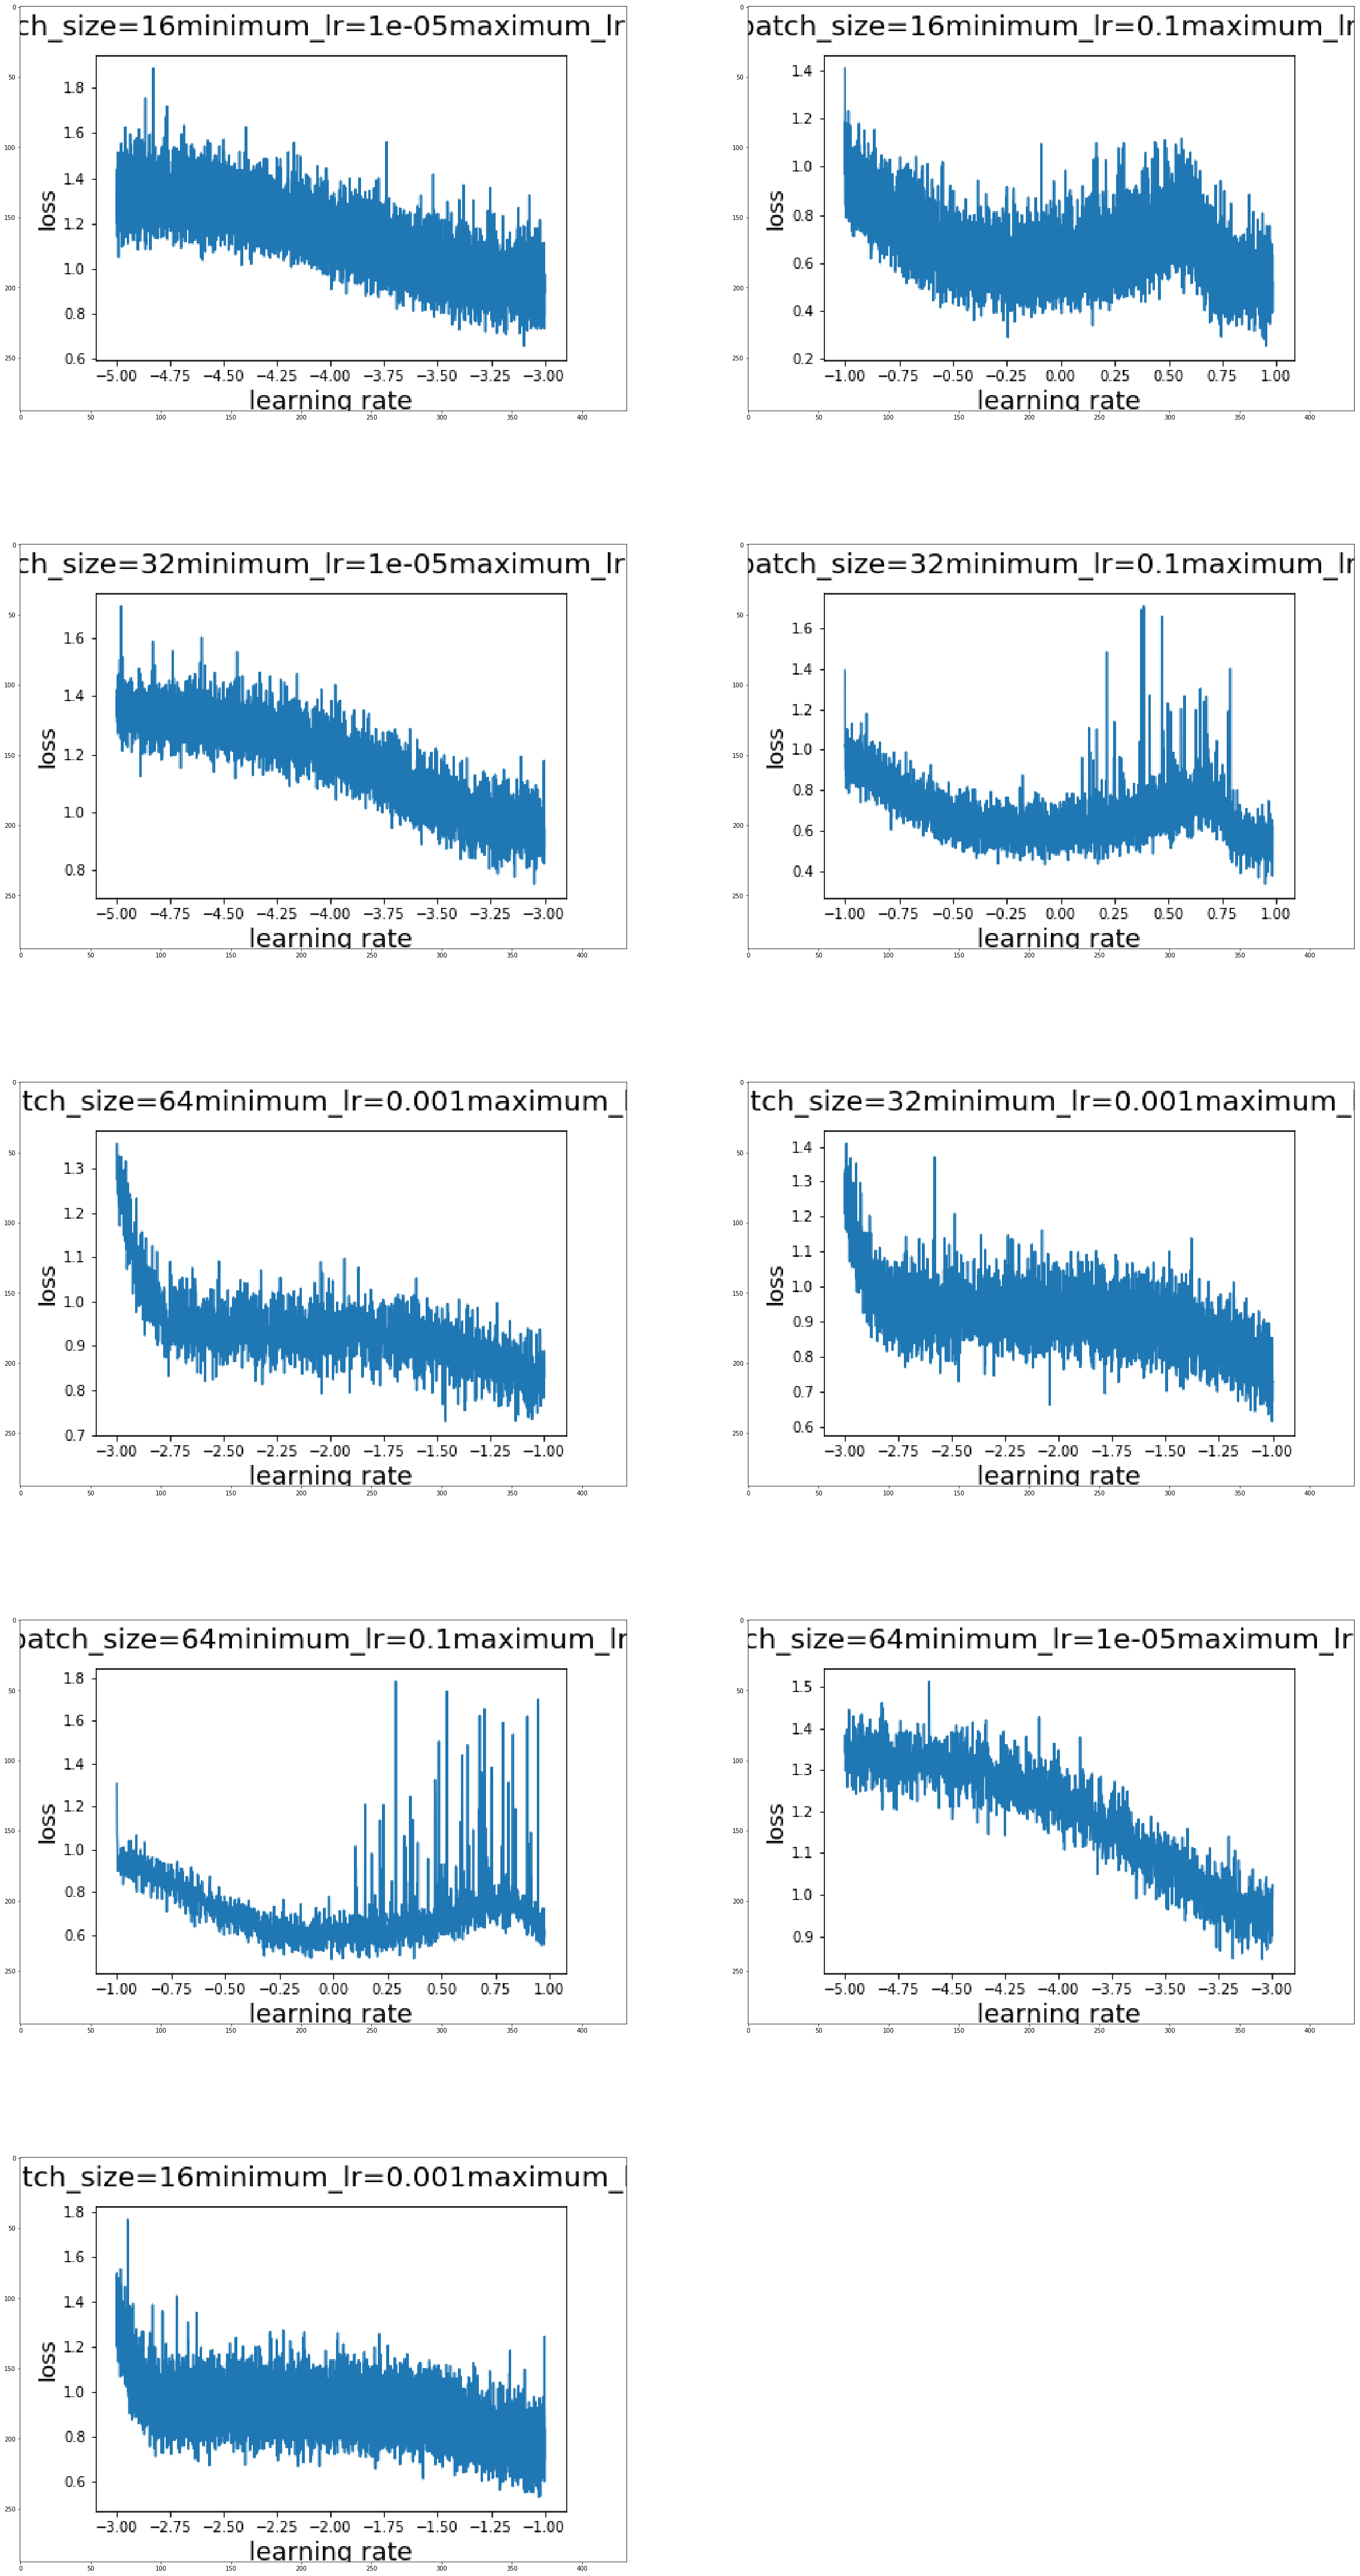

In [42]:
plt.figure(figsize=(40,80))
columns = 2
for i, image in enumerate(imgs):
    plt.subplot(len(imgs) / columns + 1, columns, i + 1)
    plt.imshow(image)